# Quickstart

Get started here. We will assess a payment default prediction model for gender fairness 
using Lens, in 5 minutes.

## Setup

Setup instruction can be found on [readthedocs](https://credoai-lens.readthedocs.io/en/stable/setup.html)

**Find the code**

This notebook can be found on [github](https://github.com/credo-ai/credoai_lens/blob/develop/docs/notebooks/quickstart.ipynb).

**Data + Model Preparation (before Lens)**

Some quick setup. This script reflects all of your datascience work before assessment and integration with Credo AI.

Here we have a gradient boosted classifier trained on the UCI Credit Card Default Dataset.

In [1]:
# model and df are defined by this script
%run training_script.py

### Imports

In [2]:
# Base Lens imports
import credoai.lens as cl
# set default format for image displays. Change to 'png' if 'svg' is failing
%config InlineBackend.figure_formats = ['svg']

## Lens in 5 minutes

Below is a basic example where our goal is to evaluate the above model. We will rely on Lens defaults for this analysis, which will automatically determine the assessments that can be run.

We'll break these down [below](#Breaking-Down-The-Steps). A feature that is worth calling out is the [report generation](#Creating-Reports)

In [3]:
# set up moden and data artifacts
credo_model = cl.CredoModel(name='credit_default_classifier',
                            model=model)

credo_data = cl.CredoData(name='UCI-credit-default',
                          data=df,
                          sensitive_feature_key='SEX',
                          label_key='target'
                          )

# specify the metrics that will be used by the Fairness and Performance assessment
metrics = ['precision_score', 'recall_score', 'equal_opportunity']
alignment_spec = {'Fairness': {'metrics': metrics},
                  'Performance': {'metrics': metrics}}
# run lens
lens = cl.Lens(model=credo_model,
               data=credo_data,
               spec=alignment_spec)
               
# first we run the assessments, then we create the report
# Note that we use method chaining to make code more readable
lens.run_assessments()#.create_report(display_results=True)

# the report can be exported to disk
# this will save in your current working directory
#lens.get_report().write_report('quickstart_report.html')

INFO:absl:Automatically Selected Assessments for model: credit_default_classifier and validation dataset: UCI-credit-default
--DatasetFairness
--DatasetProfiling
--Fairness
--Performance
INFO:absl:Initializing assessments for validation dataset: UCI-credit-default
INFO:absl:fairness metric, equal_opportunity, unused by PerformanceModule
INFO:absl:Running assessment-DatasetFairness
INFO:absl:Running assessment-DatasetProfiling


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:absl:Running assessment-Fairness
INFO:absl:Running assessment-Performance


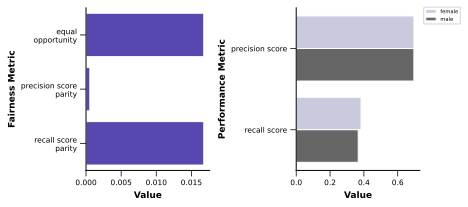

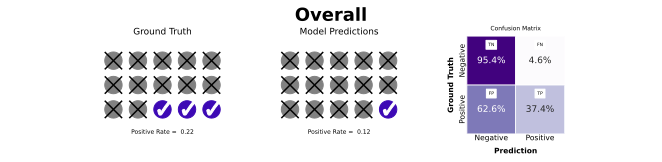

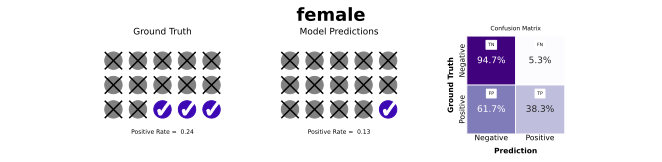

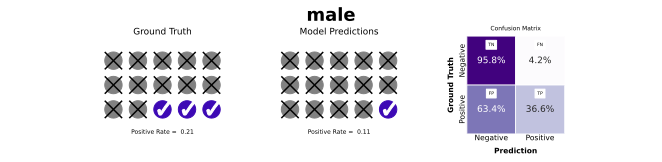

[<Figure size 1800x900 with 2 Axes>,
 <Figure size 648x129.6 with 4 Axes>,
 <Figure size 648x129.6 with 4 Axes>,
 <Figure size 648x129.6 with 4 Axes>]

In [4]:
lens.assessments['validation']['Fairness'].get_reporter().plot_results()

## In-Depth Overview

CredoAI Lens is the assessment framework component of the broader CredoAI suite.
It is usable as a standalone gateway to assessments or in combination
with CredoAI's Governance App. 

Understanding how your AI systems are operating is the most important step in intervening upon your system. From the technically complicated questions of improving a system to the business-relevant questions of whether to deploy a system - everything is fundamentally founded upon good observability. Lens strives to make assessment comprehensive, easy, and adaptable. The primary output from Lens is an **assessment report**.

### Assessments

CredoAI Lens is an entry point to assessments developed by CredoAI, as well as the broader ecosystem of open-source assessments. Custom analytics can also be folded in easily (see the `lens customization` notebook)

AI system assessment starts with verifying standard performance metrics to an evolving set of assessments falling under the banner of *Responsible AI*. A non-exhaustive list includes

* Fairness
* Explainability
* Performance
* Robustness

These different categories of assessment differ substantially based on whether one is 
evaluating datasets or models, what kind of model (e.g., tabular, NLP, computer vision), and the use-case. As the ecosystem develops, Lens will support assessing a broader range of AI systems. Currently, we are focused on Fairness.

### Reporting

Lens creates reports that summarize the assessments it performs. The reporting functionality is flexible and supports:

* Displaying tables and plots in your active notebook
* Creating standalone jupyter notebook reports 
* Exporting the standalone jupyter notebook reports to Credo AI's Governance App as HTML reports.

### Governance

While Lens is a stand-alone assessment framework, its value is increased when combined with the CredoAI Governance App. The app supports multi-stakeholder `Alignment` on how to assess your AI systems (e.g., what does good look like for this system?). It also supports translating assessment results into a Risk perspective that is scalable across your organization and understandable to diverse stakeholders.

Check out the [Connecting with Governance App](https://credoai-lens.readthedocs.io/en/latest/notebooks/governance_integration.html) for information.



## Breaking Down The Steps

### Preparing artifacts

Lens interacts with Credo Artifacts which wrap models and datasets and standardizes them for use by different assessments.
Below we create a `CredoModel` object, which automatically infers that the "model" object is from scikit-learn. We also create a `CredoData` object which is store X, y and sensitive features. Both of these objects are customizable. See `lens_customization.ipynb` for more information.


In [5]:
credo_model = cl.CredoModel(name='credit_default_classifier',
                            model=model)

credo_data = cl.CredoData(name='UCI-credit-default',
                          data=df,
                          sensitive_feature_key='SEX',
                          label_key='target'
                          )

#### CredoModel

CredoModel serves as an adapter between arbitrary models and the assessments in CredoLens. Assessments depend on CredoModel instantiating certain methods. In turn, the methods an instance of CredoModel defines informs Lens which assessment can be automatically run.

The way a CredoModel works is by defining a "config" dictionary that outlines the models functionality.

Above the CredoModel functionality was inferred from the fact that the model (GraidentBoostingClassifier) is a scikit-learn model. But under the hood all that happens was it defined a `config`.

<br>



In [6]:
# the config was inferred from the model passed to CredoModel
credo_model.config

{'pred_fun': <bound method GradientBoostingClassifier.predict of GradientBoostingClassifier()>,
 'prob_fun': <function credoai.artifacts.CredoModel._sklearn_style_config.<locals>.prob_fun(X)>}

**The Config is all that matters**

Since the `config` is all that matters, CredoModels are just wrappers around functions. They can accomodate any modeling framework, or even completely custom functions.

For instance, we could have created the above `credo_model` like so:

In [7]:
config = {'prob_fun': model.predict_proba,
          'pred_fun':  model.predict}
credo_model = cl.CredoModel(name='credit_default_classifier',
                            model_config=config)

<br>

**Using precomputed values**

A common use case you may run into is wanting to assess *pre-computed* predictions. You don't need Lens to perform inference, just use the inferences you've already generated for assessment.

Below is an example of such a case using the same example. Note that the `pred_fun` still needs to take in an `X` variable to maintain the appropriate function signature. In this case, however, X is completely ignored and the predictions are used.

In [8]:
# precomputed predictions
predictions = model.predict(X)
probs = model.predict_proba(X)
# light wrapping
config = {'pred_fun': lambda X: predictions,
          'prob_fun': lambda X: probs}
credo_model = cl.CredoModel(name='credit_default_classifier',
                            model_config=config)

#### CredoData

Just as CredoModel is an adapter between arbitrary models and the Lens assessment framework, CredoData serves as an adapter between tabular datasets and the assessments in CredoLens.

When you pass a dataframe to CredoData, CredoData separates it into an "X", "y", and, if applicable, "sensitive_features".

You can pass CredoData to Lens as a training dataset or a validation dataset. If the former, it will not be used to assess the model. Instead, dataset assessments will be performed on the dataset (e.g., fairness assessment). The validation dataset will be assessed in the same way, but _also_ used to assess the model, if provided.

In [9]:
credo_data = cl.CredoData(name='UCI-credit-default',
                          data=df,
                          sensitive_feature_key='SEX',
                          label_key='target'
                          )
credo_data.X.head(3)

,LIMIT_BAL,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,...,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
0,20000.0,2.0,1.0,24.0,2.0,2.0,-1.0,-1.0,-2.0,-2.0,...,689.0,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0
1,120000.0,2.0,2.0,26.0,-1.0,2.0,0.0,0.0,0.0,2.0,...,2682.0,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0
2,90000.0,2.0,2.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,...,13559.0,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0


### Assessments 

Lens uses the functionality of the above artifacts to automatically determine which assessments can be run. In this case the Dataset Assessment and Fairness Assessment can be run. You can see what assessments are runnable with the following function.

Assessments can be chosen, rather than inferred. See the [customizing lens notebook](https://credoai-lens.readthedocs.io/en/latest/notebooks/lens_customization.html#Selecting-Assessments) for this functionality.

In [10]:
from credoai.assessment import get_usable_assessments
get_usable_assessments(credo_model, credo_data)

{'DatasetFairness': <credoai.assessment.assessments.DatasetFairnessAssessment at 0x1774e6850>,
 'DatasetProfiling': <credoai.assessment.assessments.DatasetProfilingAssessment at 0x28bbfe1f0>,
 'Fairness': <credoai.assessment.assessments.FairnessAssessment at 0x28bbfe3d0>,
 'Performance': <credoai.assessment.assessments.PerformanceAssessment at 0x28bbfe0a0>}

You can also list all assesments, along with their names.

In [11]:
from credoai.assessment.utils import get_assessment_names
get_assessment_names()

{'DatasetFairnessAssessment': 'DatasetFairness',
 'DatasetProfilingAssessment': 'DatasetProfiling',
 'FairnessAssessment': 'Fairness',
 'NLPEmbeddingBiasAssessment': 'NLPEmbeddingBias',
 'NLPGeneratorAssessment': 'NLPGenerator',
 'PerformanceAssessment': 'Performance'}

#### Assessment-Documentation

Documentation for each assessment is a bit difficult to understand. Assessments wrap modules, which themselves have documentation. Normally, you don't have to worry about the module itself, except if you are creating your own assessments or want to use the modules directly. The main exception here is if you want to parameterize how you run the assessment

For the assessments, you may be interested in what parameters you can pass to their initialization (which is passed using the `spec` parameter when running Lens)

In [12]:
# # Different aspects of documentation you may be interested in
# # Uncomment to use
# from credoai.assessment import FairnessAssessment

# # what parameters can be passed to the initialization?
# FairnessAssessment.init_module?

# # what requirements are needed? 
# # (This is normally included in the assessments base documentation)
# assessment = FairnessAssessment()
# assessment.get_requirements()

# # what does the module require? 
# # This is often similar to the parameters passed to assessment initialization
# assessment.module?

### Alignment Spec

The Alignment Spec describes how the assessments should be run. Think about it is as the *parameterization* of the assessments Lens will run.

If you use the Credo AI Governance App, the alignment spec is a principle artifact determined during the *Alignment Phase*. It is the output of multi-stakeholder collaboration. Lens will automatically download the Alignment Spec associated with your governance credentials (which uses another artifact: `CredoGovernance`)

You can also define the spec in code. Anything defined in the spec parameter will take precedence over the spec retrieved from the Governance App.

**Setting up the Spec**

The alignment spec is a set of {assessment_name: parameter} pairs. The assessment name must be the name of one of the assessments, as returned by `get_usable_assessments` (above). In general, the name will be the name of the method without the trailing "assessment". For example, FairnessAssessment -> "Fairness". `get_assessment_names` will tell you the names you need.

The spec's parameters are passed to each Assessments `init_module` function.

Not all assessments *require* a spec, though many can be customized. In the case of "Performance" and "Fairness", a spec defining a list of metrics **is** required.

In [13]:
# specify the metrics that will be used by the Fairness assessment
alignment_spec = {
    'Fairness': {'metrics': ['precision_score']},
    'Performance': {'metrics': ['precision_score']}
}

**Supported Metrics**

Lens supports many different metrics out of the box. More can be added easily via [customization](https://credoai-lens.readthedocs.io/en/latest/notebooks/lens_customization.html#Module-Specific-Customization---Custom-Metrics-for-Fairness-Base). These metrics are used by a subset of assessments. For instance, the Performance and Fairness assessments use metrics.

In [14]:
# all out-of-the-box supported metrics can be accessed by calling list_metrics
from credoai.metrics import list_metrics
list_metrics()

defaultdict(set,
            {'BINARY_CLASSIFICATION': {'accuracy_score',
              'average_precision_score',
              'balanced_accuracy_score',
              'f1_score',
              'fallout_rate',
              'false_discovery_rate',
              'false_negative_rate',
              'false_omission_rate',
              'false_positive_rate',
              'fdr',
              'fnr',
              'fpr',
              'hit_rate',
              'matthews_correlation_coefficient',
              'miss_rate',
              'overprediction',
              'precision',
              'precision_score',
              'recall',
              'recall_score',
              'roc_auc_score',
              'selection_rate',
              'sensitivity',
              'specificity',
              'tnr',
              'tpr',
              'true_negative_rate',
              'true_positive_rate',
              'underprediction'},
             'FAIRNESS': {'demographic_parity',
          

### Run Lens

Once we have the model and data artifacts, as well as the spec, we can run Lens. By default it will automatically infer which assessments to run, just as we manually did above.

In [15]:
lens = cl.Lens(model=credo_model,
               data=credo_data,
               spec=alignment_spec)

INFO:absl:Automatically Selected Assessments for model: credit_default_classifier and validation dataset: UCI-credit-default
--DatasetFairness
--DatasetProfiling
--Fairness
--Performance
INFO:absl:Initializing assessments for validation dataset: UCI-credit-default


**Getting Assessment Results**

To run the assessments with Lens, call `run_assessments`

`run_assessments` outputs the results into a dictionary that can be used for further processing. You can also export the data to a json or straight to Credo AI's Governance App by calling `lens.export()`

In [16]:
results = lens.run_assessments().get_results()
results['validation'].keys()

INFO:absl:Running assessment-DatasetFairness
INFO:absl:Running assessment-DatasetProfiling


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:absl:Running assessment-Fairness
INFO:absl:Running assessment-Performance


dict_keys(['DatasetFairness', 'DatasetProfiling', 'Fairness', 'Performance'])

In [17]:
# get the fairness results, from the Fairness assessment, run on the validation dataset
results['validation']['Fairness']['fairness']

,value,subtype
metric_type,,
precision_score,0.000543,parity


### Creating Reports

Assessments aren't much if you can't visualize them. Lens allows you to visualize your results easily, and also packages these results into jupyter notebook reports.

To create reports, just call `create_report`. Note - not all assessments support reports! But if a report can be created, it will be. You must run the assessments before creating the report. Note that exporting reports creates much richer reports than displaying them in line.

**Displaying Plots**

If you'd like to display the plots in your active jupyter notebook, set `display_results` to True. That's what we did at the top of this notebook.

**Exporting Reports Locally**

You can also export the report to file. Lens will create another jupyter notebook which will describe all assessments you ran with Lens. This report is more feature rich than the display here, so give it a try! Just pass a location for it to save. 

Below we are saving reports to your local directory.

In [18]:
lens_report = lens.create_report().get_report()
lens_report.write_report('my_report.html')

INFO:absl:Reporter creating notebook for assessment-DatasetFairness
INFO:absl:Reporter creating notebook for assessment-DatasetProfiling
INFO:absl:Reporter creating notebook for assessment-Fairness
INFO:absl:No reporter found for assessment-Performance


**Exporting Reports To Credo AI's Governance App**

Finally, the reports can also be exported to Credo AI's Governance App. Check out the [Connecting with Governance App](https://credoai-lens.readthedocs.io/en/latest/notebooks/governance_integration.html) tutorial for directions.
